In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque

In [2]:
dataset = read_csv('/content/datasetrlfin.csv',index_col=0)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
dataset.head(5)

,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
Date,,,,,,
21-Apr-20,9016.95,9044.40,8909.40,8981.45,655122903,28273.89
22-Apr-20,9026.75,9209.75,8946.25,9187.30,734383388,33981.82
23-Apr-20,9232.35,9343.60,9170.15,9313.90,666650462,30270.55
24-Apr-20,9163.90,9296.90,9141.30,9154.40,659439249,32859.05
27-Apr-20,9259.70,9377.10,9250.35,9282.30,512793298,26696.54


In [10]:
dataset.describe()

,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
count,1243.000000,1243.000000,1243.000000,1243.000000,1.243000e+03,1243.000000
mean,18115.875583,18200.854103,18005.443644,18107.223492,3.687129e+08,27877.445270
std,4094.198555,4105.316084,4084.960202,4094.270985,1.725341e+08,9245.756344
min,8889.150000,9030.350000,8806.750000,8823.250000,3.576381e+07,1918.770000
25%,15770.350000,15838.000000,15685.900000,15757.725000,2.501548e+08,21462.455000
50%,17797.600000,17870.300000,17698.350000,17790.350000,3.039586e+08,26491.420000
75%,21696.875000,21759.425000,21542.575000,21656.675000,4.537759e+08,32699.655000
max,26248.250000,26277.350000,26151.400000,26216.050000,1.371789e+09,93786.440000


In [11]:
dataset.columns

Index(['Open ', 'High ', 'Low ', 'Close ', 'Shares Traded ',
       'Turnover (₹ Cr)'],
      dtype='object')

<Axes: xlabel='Date '>

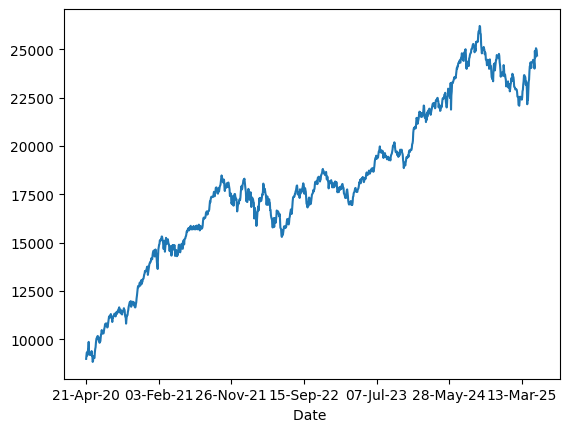

In [12]:
dataset['Close '].plot()

In [13]:
dataset=dataset.fillna(method='ffill') #for safety

In [14]:
X=list(dataset["Close "])
X=[float(x) for x in X]

In [15]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

In [5]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.core.debugger import set_trace

import numpy as np
import random
from collections import deque

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.0095
        self.epsilon_decay = 0.999
        self.model = load_model(model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state,verbose=0)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        mini_batch = random.sample(self.memory, batch_size)

        states = np.vstack([m[0] for m in mini_batch])
        next_states = np.vstack([m[3] for m in mini_batch])

        q_values = self.model.predict(states, verbose=0)
        q_next = self.model.predict(next_states, verbose=0)

        for i, (state, action, reward, next_state, done) in enumerate(mini_batch):
            target = reward
            if not done:
                target += self.gamma * np.amax(q_next[i])
            q_values[i][action] = target

        self.model.fit(states, q_values, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt

def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

def sigmoid(x):
    clipped_x = max(-709, min(709, -x))
    return 1 / (1 + math.exp(clipped_x))

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label='Buying signal', markevery=states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label='Selling signal', markevery=states_sell)
    plt.title('Total gains: %f' % profit)
    plt.legend()
    plt.show()


In [17]:
import contextlib
import sys
import os

@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [18]:
window_size = 1
agent = Agent(window_size)
data = X_train
l = len(data) - 1
batch_size = 8
episode_count = 20

Running episode 0/20
--------------------------------
Total Profit: $85140.05
--------------------------------


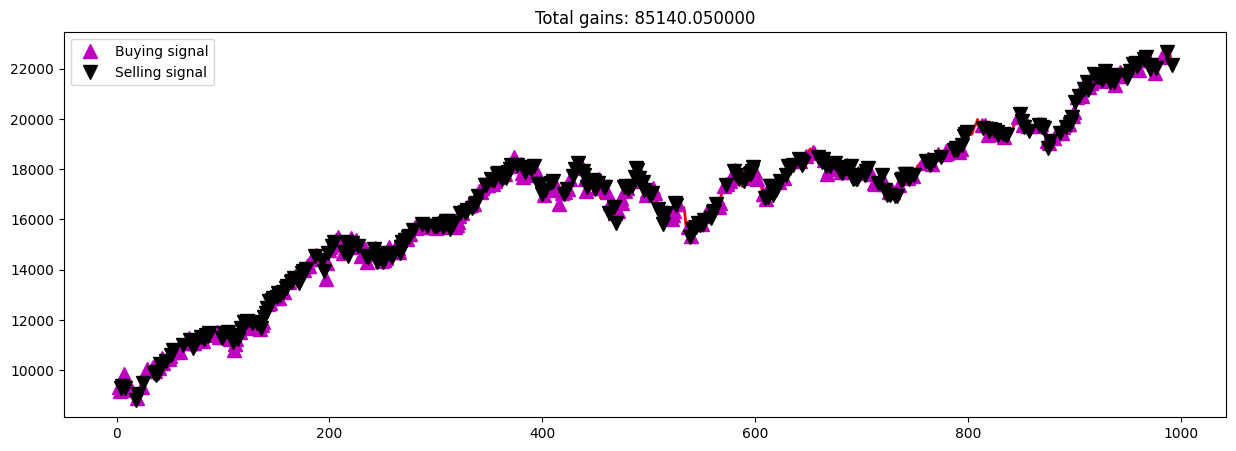

Running episode 1/20
--------------------------------
Total Profit: $31812.55
--------------------------------


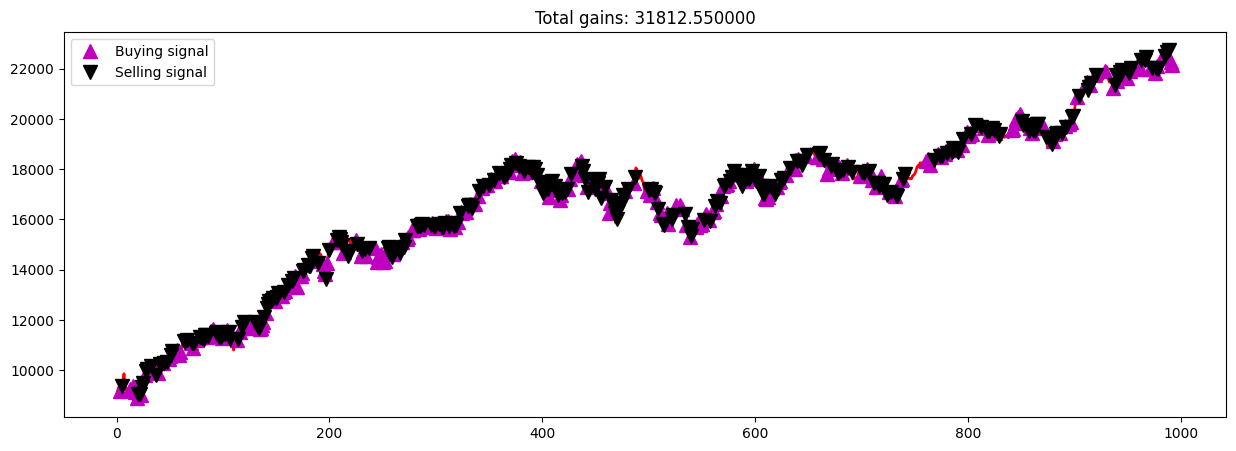

Running episode 2/20
--------------------------------
Total Profit: $25659.95
--------------------------------


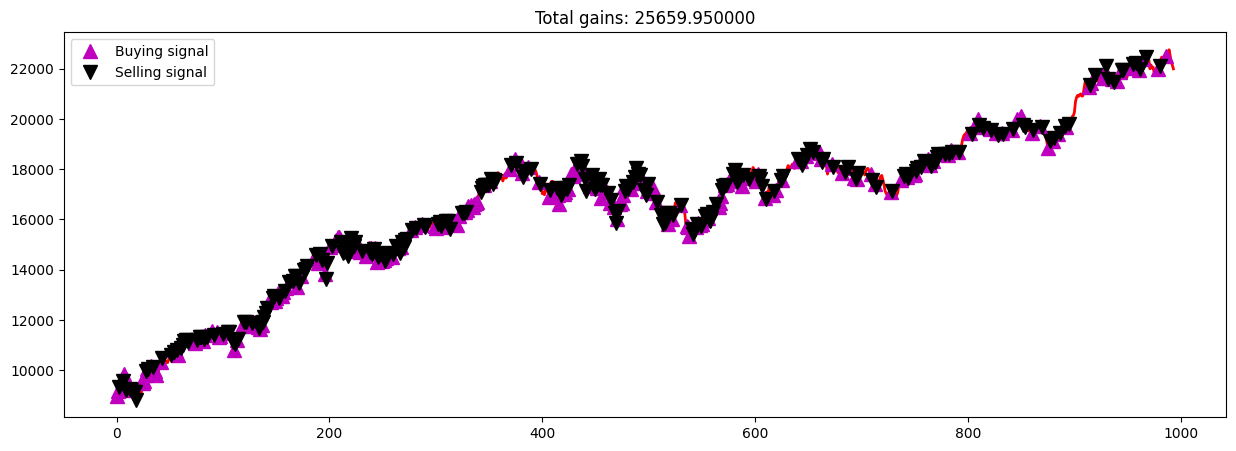

Running episode 3/20
--------------------------------
Total Profit: $6342.45
--------------------------------


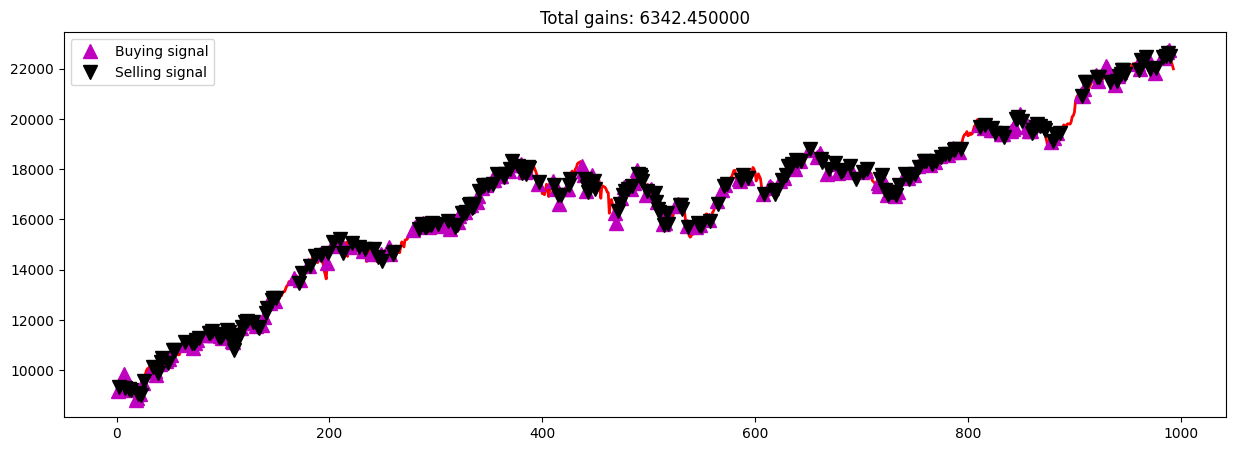

Running episode 4/20
--------------------------------
Total Profit: $10513.10
--------------------------------


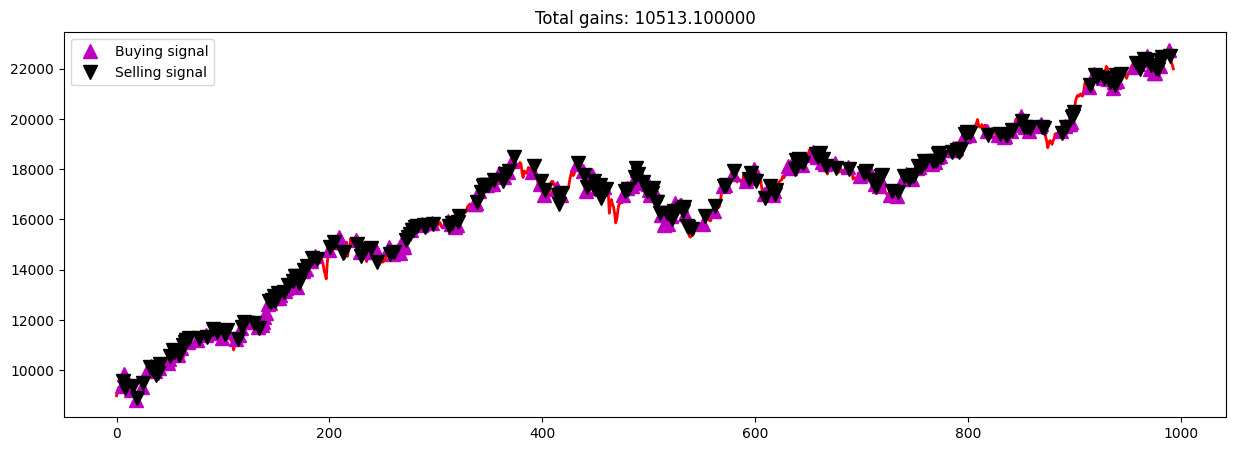

Running episode 5/20
--------------------------------
Total Profit: $11579.95
--------------------------------


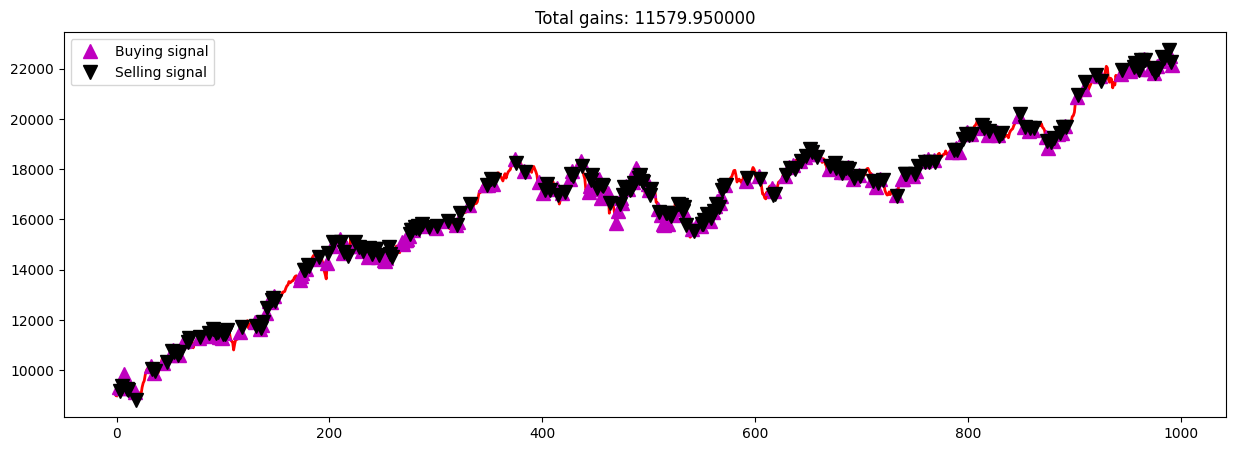

Running episode 6/20
--------------------------------
Total Profit: $3829.05
--------------------------------


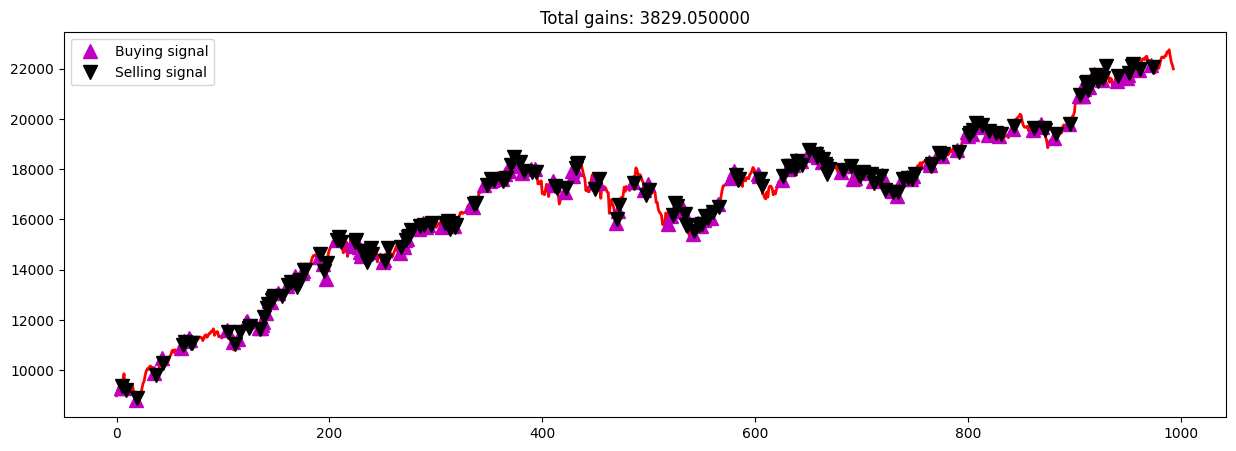

Running episode 7/20
--------------------------------
Total Profit: -$2425.25
--------------------------------


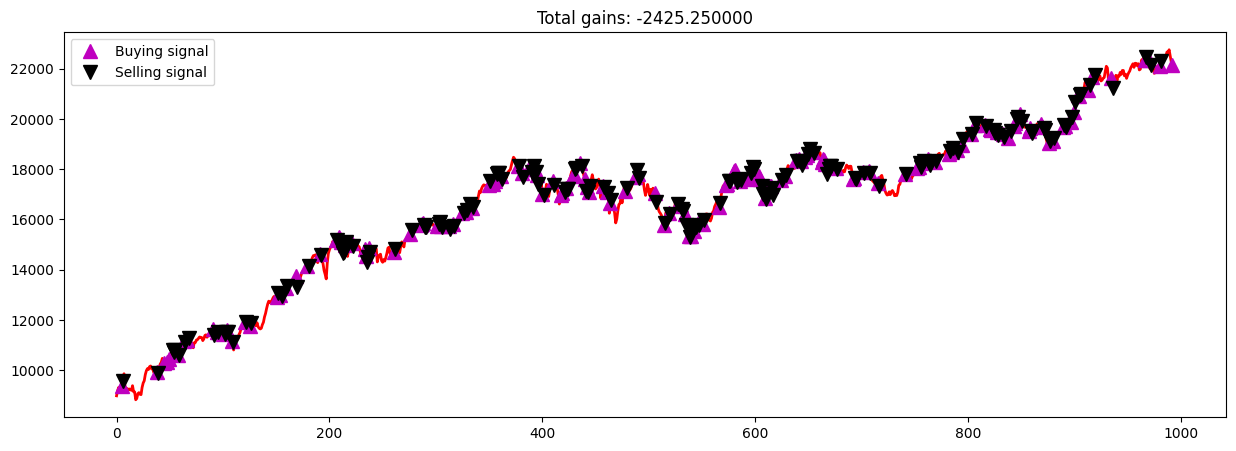

Running episode 8/20
--------------------------------
Total Profit: $2896.80
--------------------------------


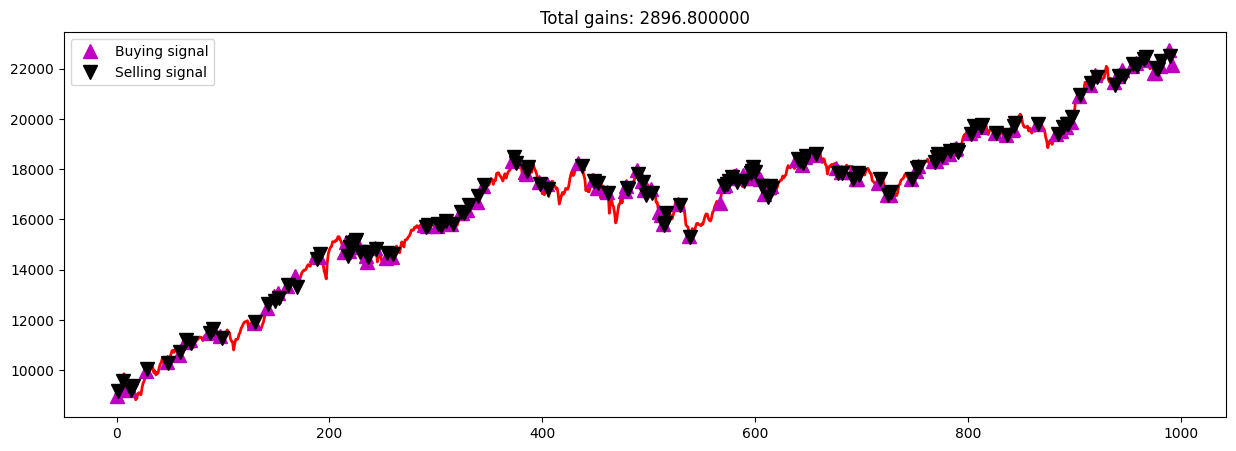

Running episode 9/20
--------------------------------
Total Profit: $5741.00
--------------------------------


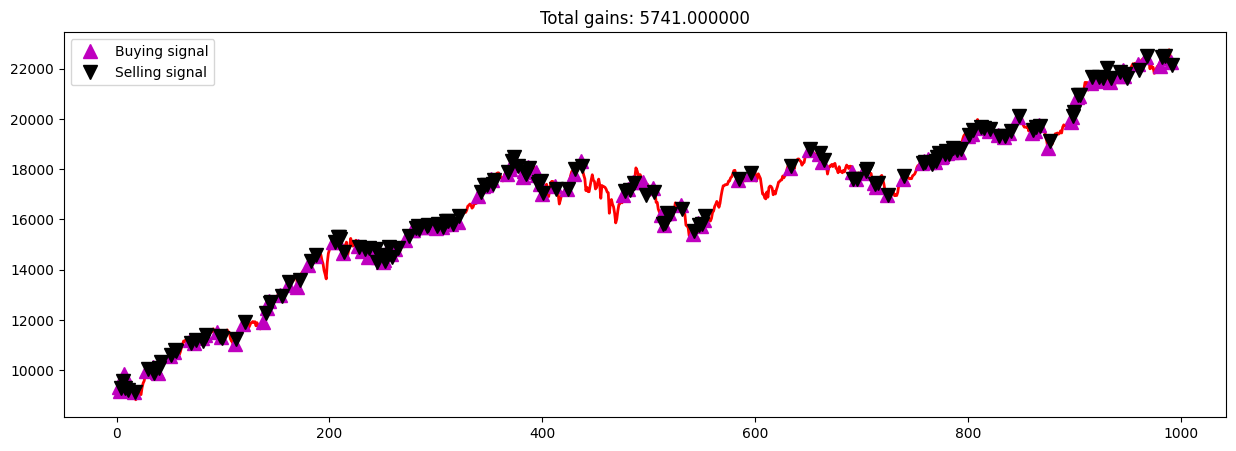

Running episode 10/20
--------------------------------
Total Profit: $2237.75
--------------------------------


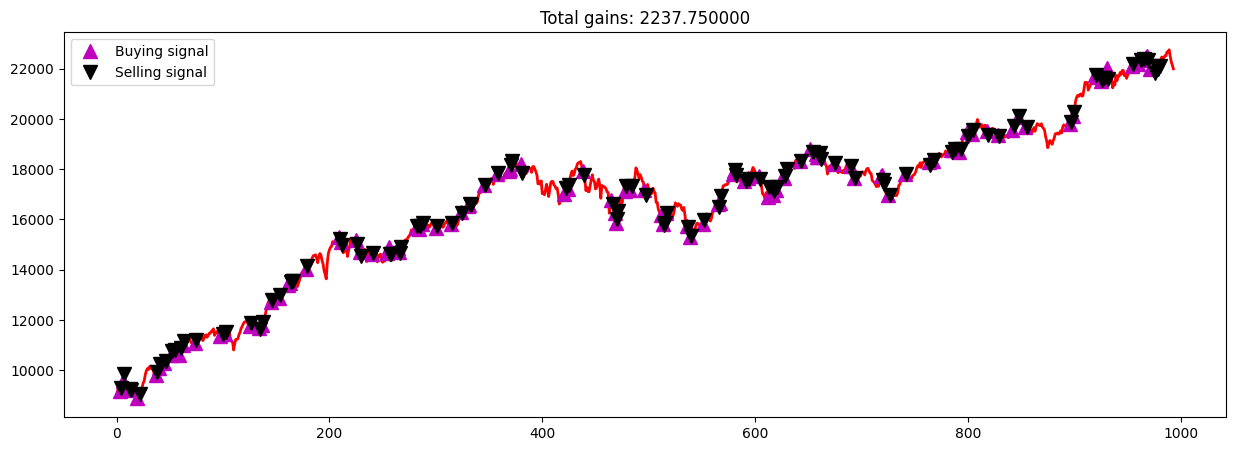

Running episode 11/20
--------------------------------
Total Profit: $3601.50
--------------------------------


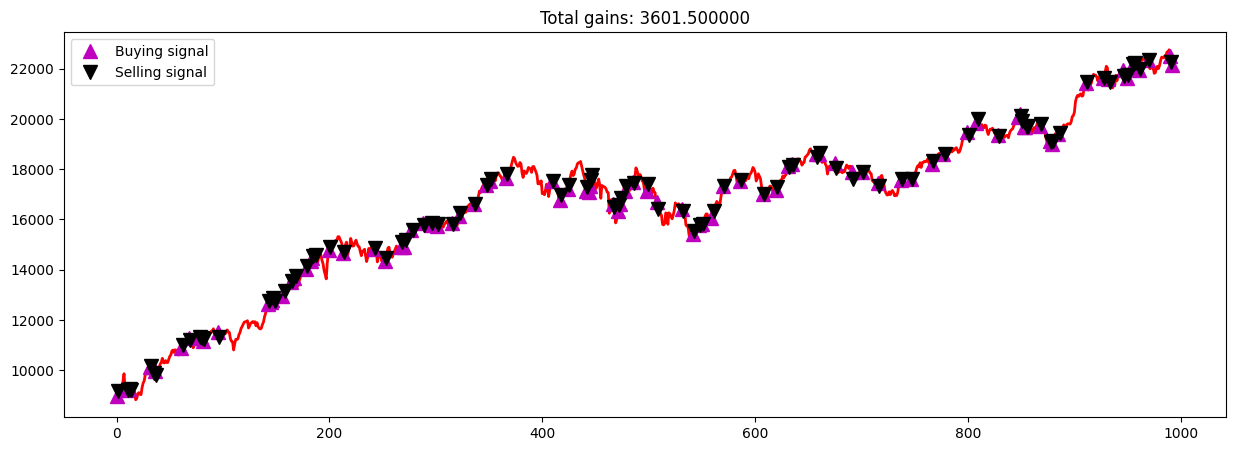

Running episode 12/20
--------------------------------
Total Profit: -$2837.80
--------------------------------


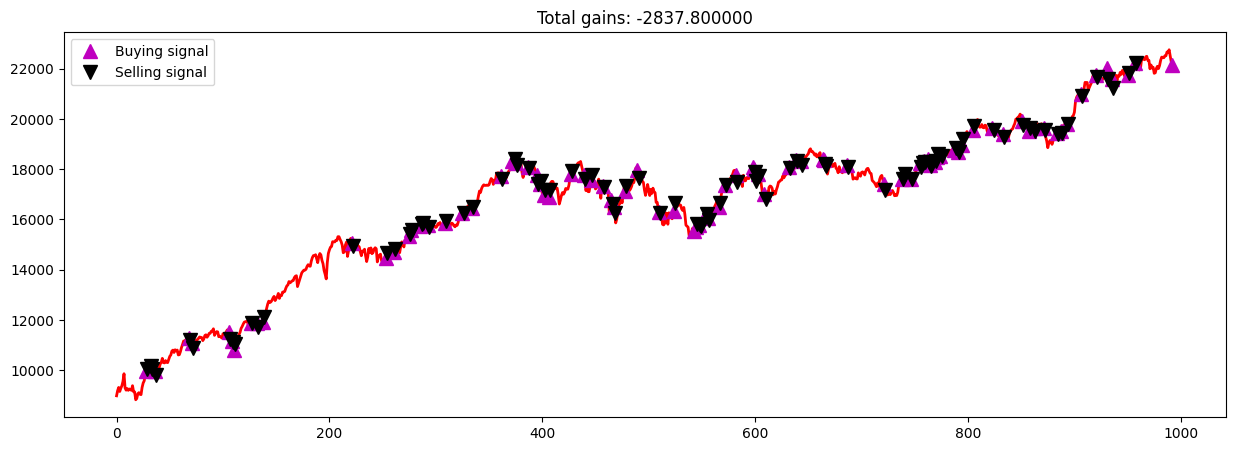

Running episode 13/20
--------------------------------
Total Profit: $617.10
--------------------------------


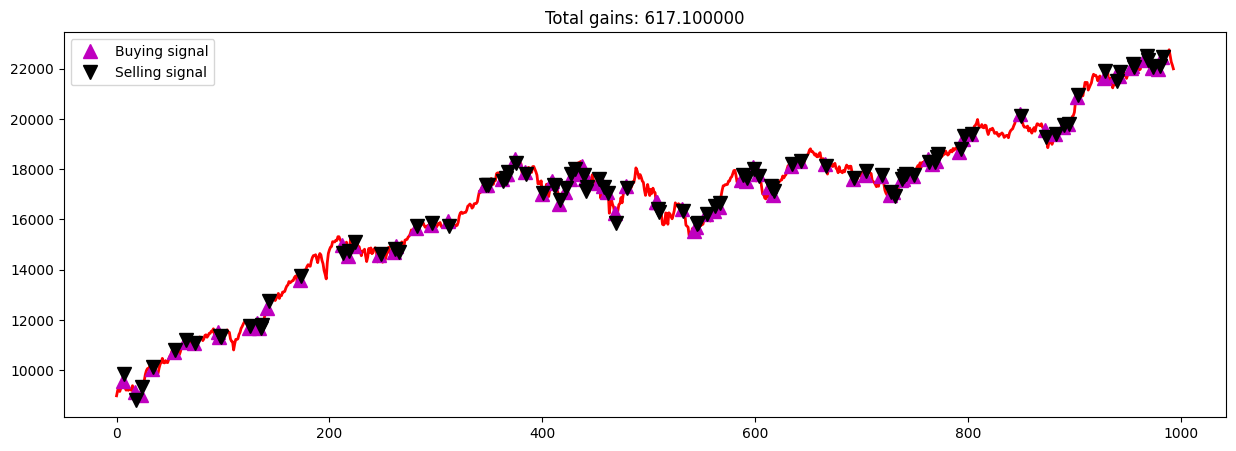

Running episode 14/20
--------------------------------
Total Profit: $209.45
--------------------------------


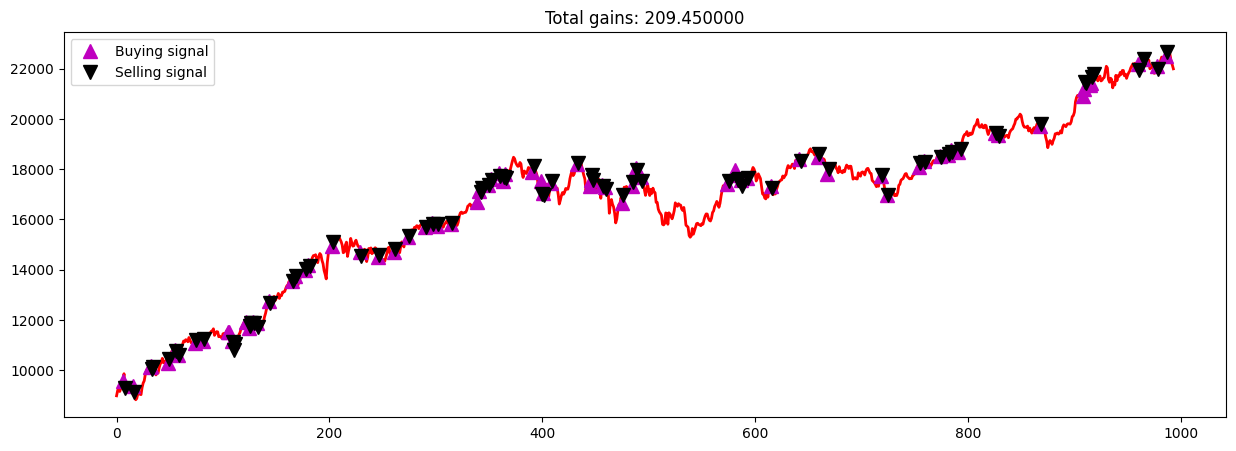

Running episode 15/20
--------------------------------
Total Profit: -$919.60
--------------------------------


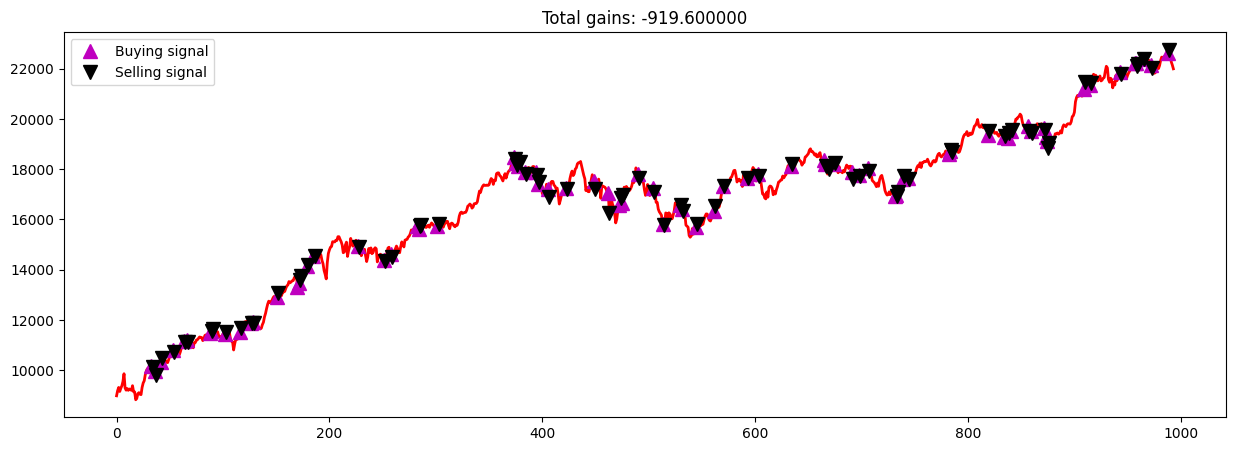

Running episode 16/20
--------------------------------
Total Profit: $2902.80
--------------------------------


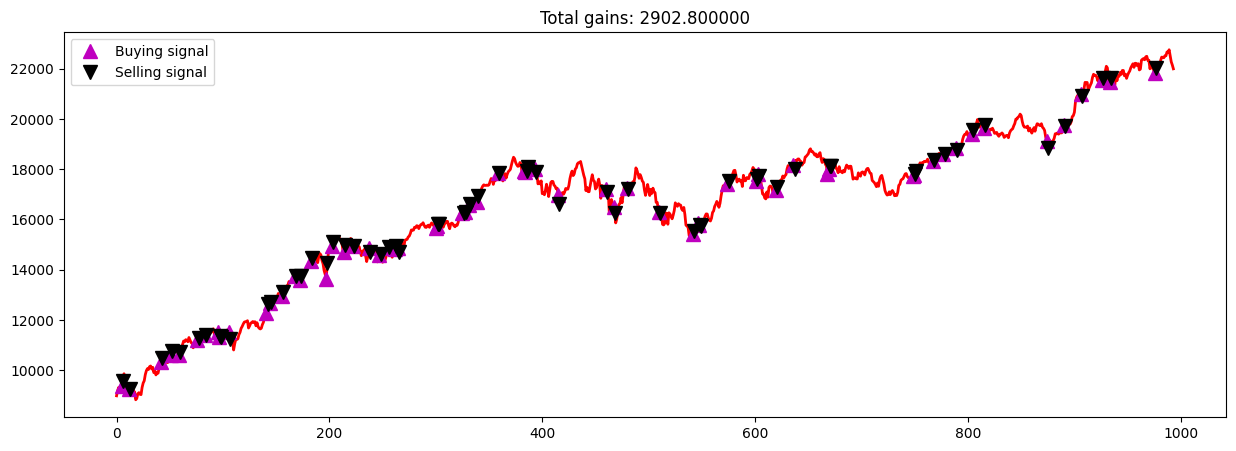

Running episode 17/20
--------------------------------
Total Profit: -$207.40
--------------------------------


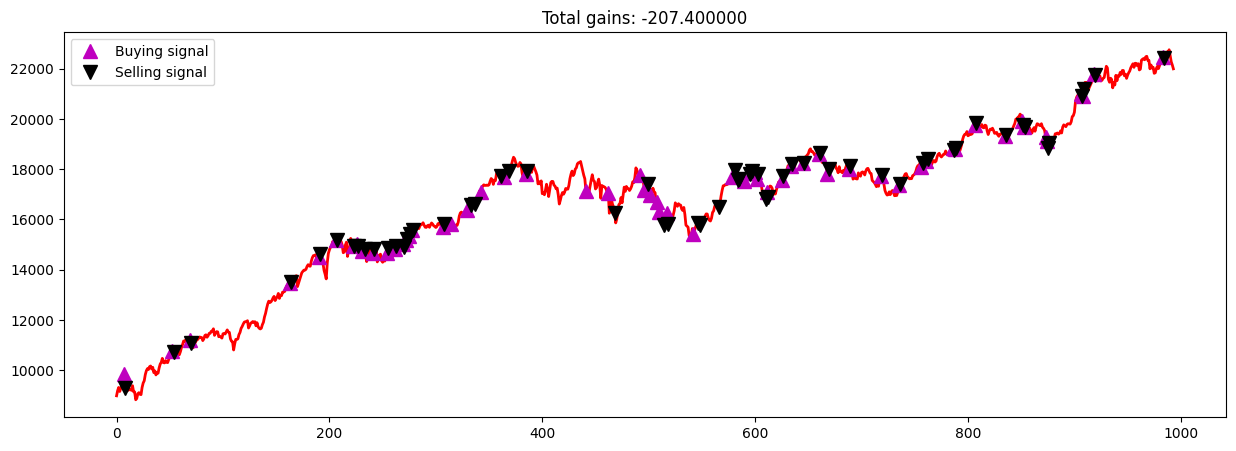

Running episode 18/20
--------------------------------
Total Profit: $1018.75
--------------------------------


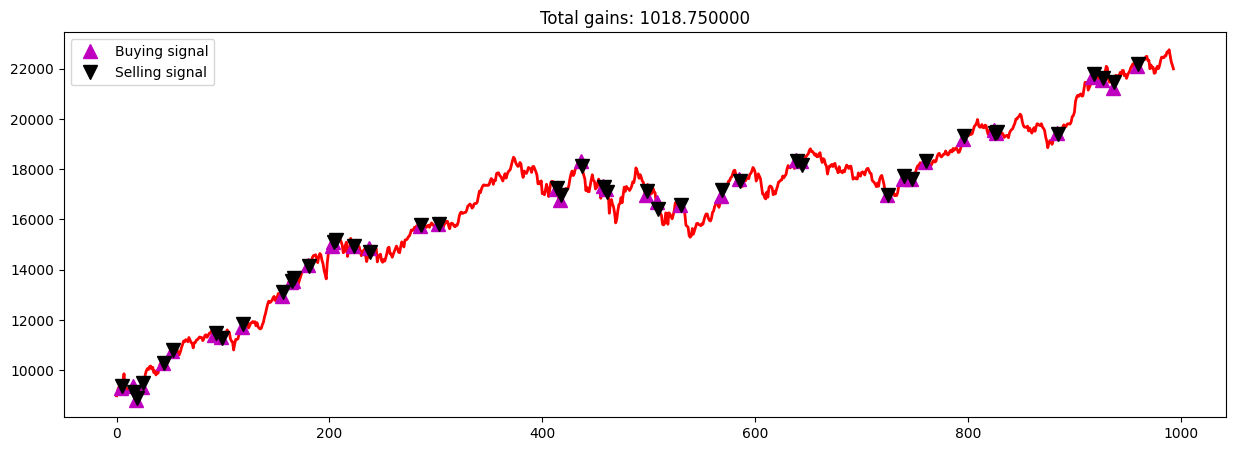

Running episode 19/20
--------------------------------
Total Profit: -$1517.60
--------------------------------


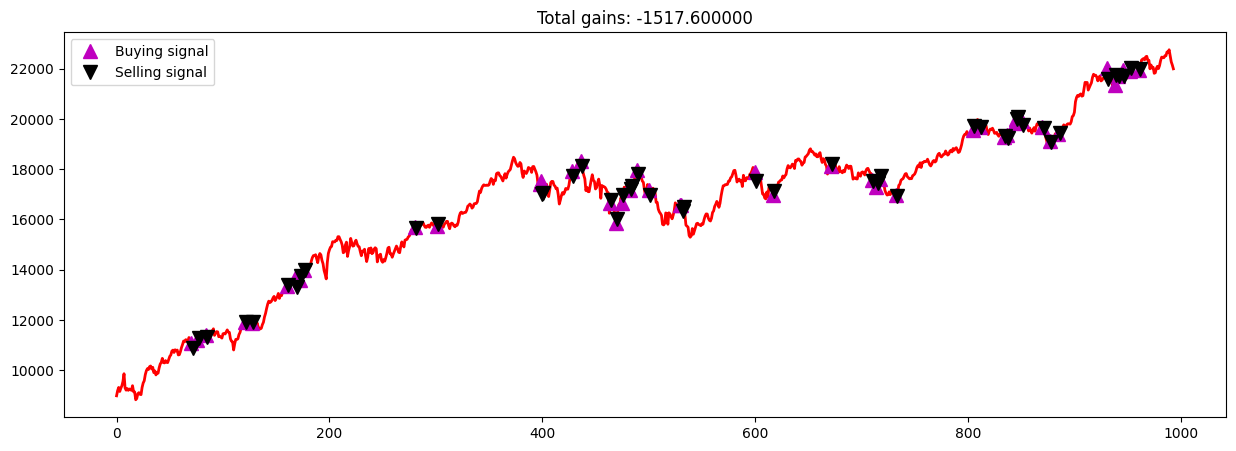

Running episode 20/20
--------------------------------
Total Profit: $555.75
--------------------------------


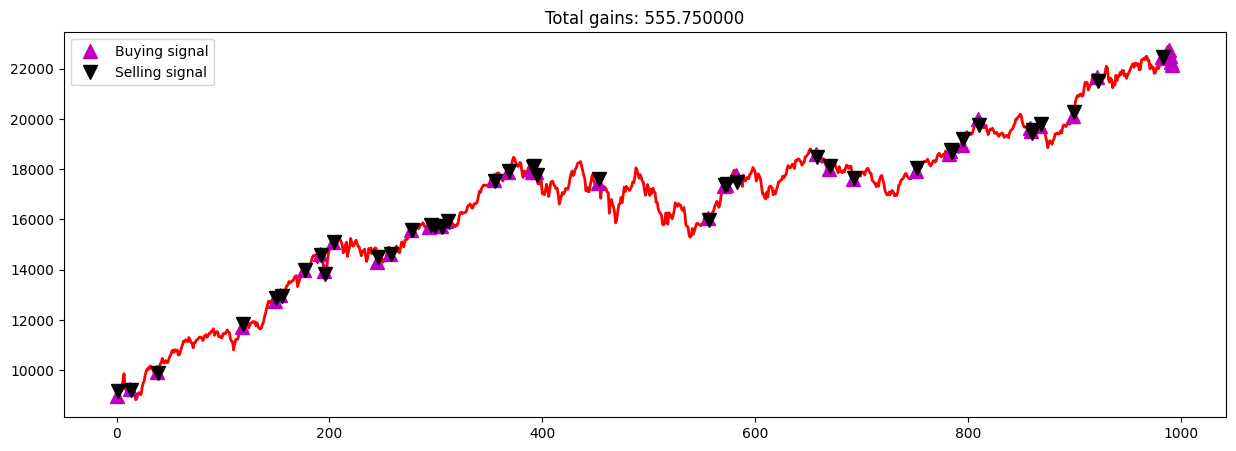

In [ ]:
from IPython.core.debugger import set_trace

window_size = 1
agent = Agent(window_size)
data = X_train
l = len(data) - 1
batch_size = 8
episode_count = 20

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    for t in range(l):
        action = agent.act(state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1:
            agent.inventory.append(data[t])
            states_buy.append(t)

        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)

        done = t == l - 1
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            plot_behavior(data, states_buy, states_sell, total_profit)

        if t%10==0 and len(agent.memory) > batch_size:
            with suppress_stdout():
              agent.expReplay(batch_size)

    if e % 2 == 0:
      agent.model.save(f"model_ep{e}.keras")

In [ ]:
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
#Get the trained model
model_name = "model_ep"+str(episode_count)+".keras"
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

Buy: $22147.00
Buy: $22529.05
Buy: $22597.80
Buy: $22967.65
Buy: $22957.10
Buy: $22932.45
Buy: $22888.15
Buy: $22704.70
Buy: $22488.65
Buy: $22530.70
Buy: $23263.90
Buy: $21884.50
Buy: $22620.35
Buy: $22821.40
Buy: $23290.15
Buy: $23259.20
Buy: $23264.85
Buy: $23322.95
Buy: $23398.90
Buy: $23465.60
Buy: $23557.90
Buy: $23516.00
Buy: $23567.00
Buy: $23501.10
Buy: $23537.85
Buy: $23721.30
Buy: $23868.80
Buy: $24044.50
Buy: $24010.60
Buy: $24141.95
Buy: $24123.85
Buy: $24286.50
Buy: $24302.15
Buy: $24323.85
Buy: $24320.55
Buy: $24433.20
Buy: $24324.45
Buy: $24315.95
Buy: $24502.15
Buy: $24586.70
Buy: $24613.00
Buy: $24800.85
Buy: $24530.90
Buy: $24509.25
Buy: $24479.05
Buy: $24413.50
Buy: $24406.10
Buy: $24834.85
Buy: $24836.10
Buy: $24857.30
Buy: $24951.15
Buy: $25010.90
Buy: $24717.70
Buy: $24055.60
Buy: $23992.55
Buy: $24297.50
Buy: $24117.00
Buy: $24367.50
Buy: $24347.00
Buy: $24139.00
Buy: $24143.75
Buy: $24541.15
Buy: $24572.65
Buy: $24698.85
Buy: $24770.20
Buy: $24811.50
Buy: $2482

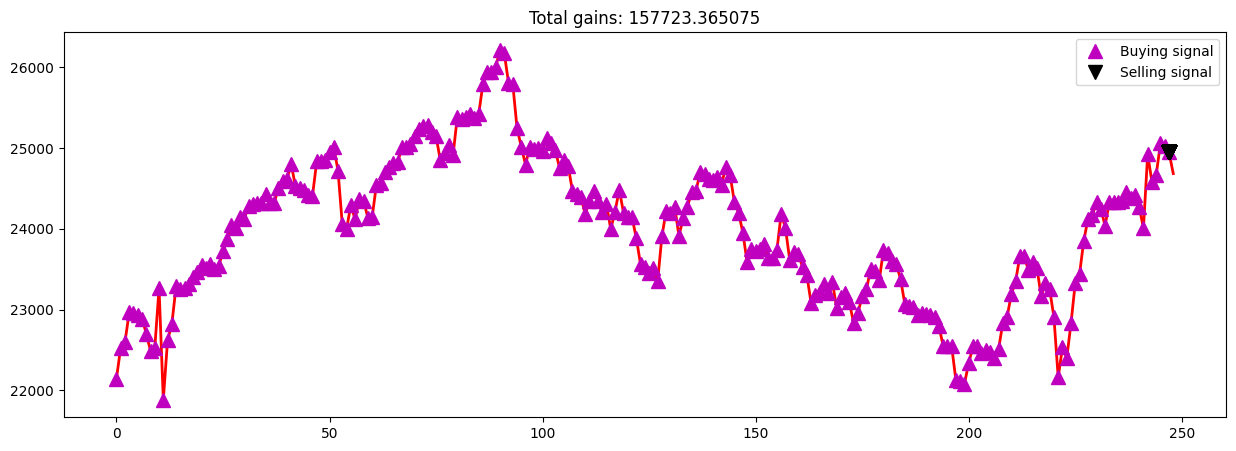

In [ ]:
TRANSACTION_FEE_RATE = 0.0015  # 0.15%

state = getState(test_data, 0, window_size + 1)
total_profit = 0
total_invested = 0
agent.inventory = []
states_buy_test = []
states_sell_test = []

for t in range(l_test):
    action = agent.act(state)
    next_state = getState(test_data, t + 1, window_size + 1)
    price = test_data[t]

    if action == 1:
        agent.inventory.append(price)
        total_invested += price + (price * TRANSACTION_FEE_RATE)
        states_buy_test.append(t)
        print("Buy: " + formatPrice(price))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        sell_fee = price * TRANSACTION_FEE_RATE
        buy_fee = bought_price * TRANSACTION_FEE_RATE
        profit = price - bought_price - sell_fee - buy_fee
        total_profit += profit
        states_sell_test.append(t)
        print("Sell: " + formatPrice(price) + " | Profit: " + formatPrice(profit))

    state = next_state

final_price = test_data[-1]
while len(agent.inventory) > 0:
    bought_price = agent.inventory.pop(0)
    sell_fee = final_price * TRANSACTION_FEE_RATE
    buy_fee = bought_price * TRANSACTION_FEE_RATE
    profit = final_price - bought_price - sell_fee - buy_fee
    total_profit += profit
    total_invested += bought_price + buy_fee  # Include buy cost of unsold shares
    states_sell_test.append(l_test - 1)
    print("Final Sell: " + formatPrice(final_price) + " | Profit: " + formatPrice(profit))

# 📈 Calculate % return
if total_invested > 0:
    return_pct = (total_profit / total_invested) * 100
else:
    return_pct = 0

print("------------------------------------------")
print("Total Profit: " + formatPrice(total_profit))
print("Total Invested: " + formatPrice(total_invested))
print("Return: {:.2f}%".format(return_pct))
print("------------------------------------------")

plot_behavior(test_data, states_buy_test, states_sell_test, total_profit)


In [ ]:
import random
import itertools
import numpy as np
from copy import deepcopy

# Define search space
search_space = {
    "gamma": [0.90, 0.95, 0.99],
    "epsilon_decay": [0.999],
    "learning_rate": [1e-4, 1e-3, 1e-2],
    "batch_size": [8, 16, 32],
    "dense_units": [(64, 32, 8), (128, 64, 32)]
}

# How many trials to run
num_trials = 5
results = []
TRANSACTION_FEE_RATE = 0.0015
# Sample hyperparameter combos
def sample_config():
    return {
        "gamma": random.choice(search_space["gamma"]),
        "epsilon_decay": random.choice(search_space["epsilon_decay"]),
        "learning_rate": random.choice(search_space["learning_rate"]),
        "batch_size": random.choice(search_space["batch_size"]),
        "dense_units": random.choice(search_space["dense_units"])
    }

# Agent class with configurable params
class TunedAgent(Agent):
    def __init__(self, state_size, config):
        self.state_size = state_size
        self.action_size = 3
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.gamma = config["gamma"]
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = config["epsilon_decay"]
        self.learning_rate = config["learning_rate"]
        self.units = config["dense_units"]
        self.model = self._model()
        self.is_eval = False

    def _model(self):
        model = Sequential()
        model.add(Dense(units=self.units[0], input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=self.units[1], activation="relu"))
        model.add(Dense(units=self.units[2], activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=self.learning_rate))
        return model

# Run trials
for i in range(num_trials):
    config = sample_config()
    agent = TunedAgent(window_size, config)

    # Train agent (shortened, 1–3 episodes)
    for e in range(2):
        state = getState(X_train, 0, window_size + 1)
        total_profit = 0
        agent.inventory = []

        for t in range(len(X_train) - 1):
            action = agent.act(state)
            next_state = getState(X_train, t + 1, window_size + 1)
            reward = 0

            if action == 1:
                agent.inventory.append(X_train[t])
            elif action == 2 and agent.inventory:
                bought_price = agent.inventory.pop(0)
                fee = X_train[t] * TRANSACTION_FEE_RATE
                reward = max(X_train[t] - bought_price - 2 * fee, 0)
                total_profit += reward
            done = t == len(X_train) - 2
            agent.memory.append((state, action, reward, next_state, done))
            state = next_state
            if t%20==0 and len(agent.memory) > config["batch_size"]:
                agent.expReplay(config["batch_size"])

    # Test agent
    state = getState(X_test, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []

    for t in range(len(X_test) - 1):
        action = agent.act(state)
        next_state = getState(X_test, t + 1, window_size + 1)
        price = X_test[t]

        if action == 1:
            agent.inventory.append(price)
        elif action == 2 and agent.inventory:
            bought_price = agent.inventory.pop(0)
            fee = price * TRANSACTION_FEE_RATE
            total_profit += price - bought_price - 2 * fee

        state = next_state

    # Liquidate
    final_price = X_test[-1]
    while agent.inventory:
        bought_price = agent.inventory.pop(0)
        fee = final_price * TRANSACTION_FEE_RATE
        total_profit += final_price - bought_price - 2 * fee

    total_invested = sum(X_test[i] + X_test[i] * TRANSACTION_FEE_RATE for i in range(len(X_test)) if i in agent.inventory)
    return_pct = (total_profit / total_invested) * 100 if total_invested > 0 else 0
    results.append((deepcopy(config), return_pct))
    print(f"Trial {i+1}: Return {return_pct:.2f}% | Config: {config}")

# Sort by return
results.sort(key=lambda x: x[1], reverse=True)
print("\nTop Configs:")
for config, ret in results[:3]:
    print(f"Return: {ret:.2f}% | Config: {config}")
